# SNR finder ANN model training

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from ler.utils import add_dict_values

In [2]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("optsnr_A1.json")

print(len(unlensed_params['A1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['A1']<1000
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

len(unlensed_params['A1'])

100079


100076

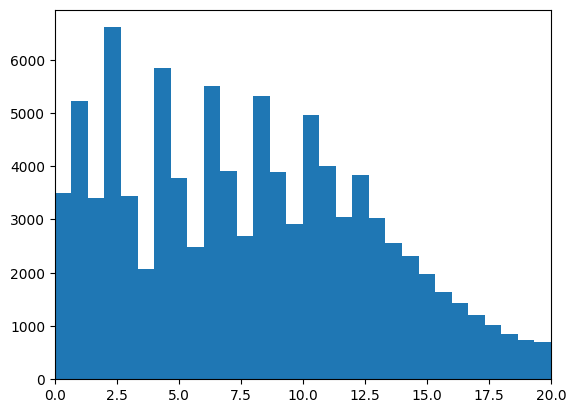

In [3]:
# visualize the data
import matplotlib.pyplot as plt
test = np.array(unlensed_params['A1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [4]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR

gwsnr = GWSNR(
    mtot_max=500,
    minimum_frequency=10,
    waveform_approximant='IMRPhenomXPHM',
    snr_type='ann',
    ifos=['A1'],
)

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for A1 detector from ./interpolator_pickle/A1/partialSNR_dict_0.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  10
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10): 369.97199706893525
detectors:  ['A1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/Aplus_asd.txt')]


## Input-Output generator function

In [5]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = params['mass_1'][idx]
    mass_2 = params['mass_2'][idx]
    luminosity_distance = params['luminosity_distance'][idx]
    theta_jn = params['theta_jn'][idx]
    psi = params['psi'][idx]
    geocent_time = params['geocent_time'][idx]
    ra = params['ra'][idx]
    dec = params['dec'][idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = params['a_1'][idx]
    a_2 = params['a_2'][idx]
    tilt_1 = params['tilt_1'][idx]
    tilt_2 = params['tilt_2'][idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    XA1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get A1 snr for y train
    yA1 = params['A1'][idx]


    return(XA1, yA1)

In [6]:
len_ = len(unlensed_params['A1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XA1, yA1 = input_output(idx, unlensed_params)
np.shape(XA1)

(100076, 5)

## A1

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XA1, yA1, test_size = 0.1, random_state = 0)

In [8]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerA1.pkl', 'wb'))

In [10]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [11]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [12]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200
2815/2815 [==============================] - 1s 417us/step - loss: 40.2611 - accuracy: 3.3308e-05
Epoch 2/200
2815/2815 [==============================] - 1s 416us/step - loss: 13.7292 - accuracy: 0.0000e+00
Epoch 3/200
2815/2815 [==============================] - 1s 433us/step - loss: 9.2167 - accuracy: 0.0000e+00
Epoch 4/200
2815/2815 [==============================] - 1s 417us/step - loss: 7.0939 - accuracy: 3.3308e-05
Epoch 5/200
2815/2815 [==============================] - 1s 411us/step - loss: 5.9369 - accuracy: 1.1103e-04
Epoch 6/200
2815/2815 [==============================] - 1s 404us/step - loss: 5.1555 - accuracy: 1.3323e-04
Epoch 7/200
2815/2815 [==============================] - 1s 409us/step - loss: 4.5595 - accuracy: 1.5544e-04
Epoch 8/200
2815/2815 [==============================] - 1s 402us/step - loss: 4.1612 - accuracy: 2.2205e-04
Epoch 9/200
2815/2815 [==============================] - 1s 408us/step - loss: 3.8282 - accuracy: 1.7764e-04
Epoch 10/200
2815

In [13]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

313/313 [==============================] - 0s 268us/step
[[ 3.34899235  3.01396509]
 [ 2.73190928  3.02530433]
 [ 8.18550491  8.23130136]
 [ 2.38396072  2.62879386]
 [ 6.52676153  7.00563595]
 [13.26651573 13.80389481]
 [20.79534721 18.87407049]
 [13.75183105 14.61486402]
 [ 6.30413485  6.52569197]
 [ 6.16427374  6.21700781]
 [ 5.93020916  6.33134849]
 [14.2387104  14.28390645]
 [12.22118378 12.1187982 ]
 [ 1.88224697  2.00148308]
 [ 2.43541813  1.39694671]]


In [14]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.62%


In [15]:
# Save the model to a file
ann.save('ann_modelA1.h5')

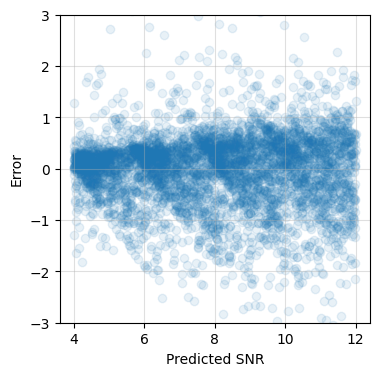

In [16]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

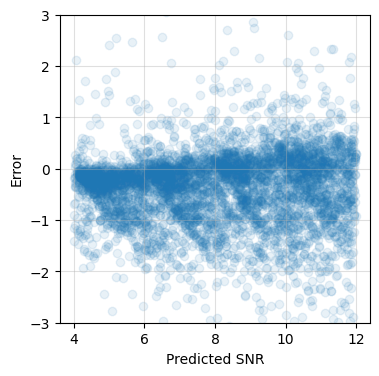

In [362]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), (y_pred>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[4660  155]
 [ 207 4986]]


0.9638289368505196

## CE

In [18]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("optsnr_CE_1.json")
# unlensed_params2 = get_param_from_json("optsnr_CE_2.json")
# unlensed_params3 = get_param_from_json("optsnr_CE_3.json")
# unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
# unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
# #del unlensed_params2
# del unlensed_params2, unlensed_params3

print(len(unlensed_params['CE']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['CE']<1000
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

len(unlensed_params['CE'])

100000


99996

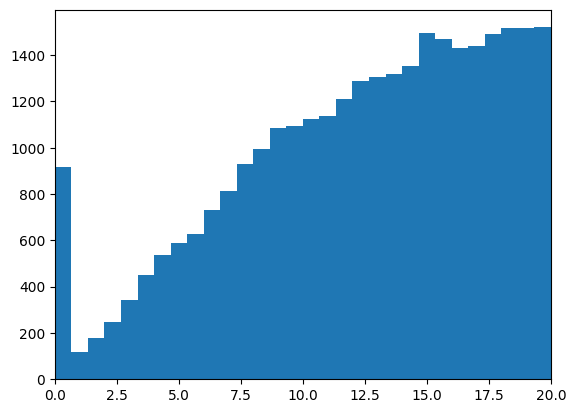

In [19]:
# visualize the data
import matplotlib.pyplot as plt
test = np.array(unlensed_params['CE'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [20]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR

gwsnr = GWSNR(
    mtot_max=500,
    minimum_frequency=10,
    waveform_approximant='IMRPhenomXPHM',
    snr_type='ann',
    ifos=['CE'],
)

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for CE detector from ./interpolator_pickle/CE/partialSNR_dict_0.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  10
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10): 369.97199706893525
detectors:  ['CE']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt', asd_file='None')]


In [21]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = params['mass_1'][idx]
    mass_2 = params['mass_2'][idx]
    luminosity_distance = params['luminosity_distance'][idx]
    theta_jn = params['theta_jn'][idx]
    psi = params['psi'][idx]
    geocent_time = params['geocent_time'][idx]
    ra = params['ra'][idx]
    dec = params['dec'][idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    CE = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  CE / d_eff

    # get spin parameters
    a_1 = params['a_1'][idx]
    a_2 = params['a_2'][idx]
    tilt_1 = params['tilt_1'][idx]
    tilt_2 = params['tilt_2'][idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    XCE = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get CE snr for y train
    yCE = params['CE'][idx]


    return(XCE, yCE)

In [22]:
len_ = len(unlensed_params['CE'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XCE, yCE = input_output(idx, unlensed_params)
np.shape(XCE)

(99996, 5)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XCE, yCE, test_size = 0.1, random_state = 0)

In [24]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [25]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerCE.pkl', 'wb'))

In [26]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [27]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [28]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


2813/2813 [==============================] - 1s 410us/step - loss: 1696.4058 - accuracy: 1.3334e-04
Epoch 2/200
2813/2813 [==============================] - 1s 408us/step - loss: 794.1298 - accuracy: 0.0000e+00
Epoch 3/200
2813/2813 [==============================] - 1s 413us/step - loss: 521.5956 - accuracy: 0.0000e+00
Epoch 4/200
2813/2813 [==============================] - 1s 421us/step - loss: 395.3189 - accuracy: 0.0000e+00
Epoch 5/200
2813/2813 [==============================] - 1s 431us/step - loss: 326.9442 - accuracy: 0.0000e+00
Epoch 6/200
2813/2813 [==============================] - 1s 427us/step - loss: 284.1144 - accuracy: 0.0000e+00
Epoch 7/200
2813/2813 [==============================] - 1s 425us/step - loss: 255.2185 - accuracy: 0.0000e+00
Epoch 8/200
2813/2813 [==============================] - 1s 420us/step - loss: 232.8365 - accuracy: 0.0000e+00
Epoch 9/200
2813/2813 [==============================] - 1s 410us/step - loss: 215.8377 - accuracy: 0.0000e+00
Epoch 10/200

In [29]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

  1/313 [..............................] - ETA: 8s

313/313 [==============================] - 0s 280us/step
[[41.23482132 39.94741375]
 [ 8.98449135  8.53934228]
 [27.49624252 26.96024093]
 [ 4.65736961  2.84814154]
 [74.08576965 74.95277469]
 [ 8.11702156  6.99645784]
 [71.49602509 72.96137991]
 [20.23032951 20.35630539]
 [ 5.45152092  0.51285542]
 [45.27699661 41.88174552]
 [23.25246811 22.61537792]
 [11.95618248 12.16545479]
 [23.73601532 26.51086186]
 [42.78129959 41.16293526]
 [20.55005264 20.75671389]]


In [30]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.94%


In [31]:
# Save the model to a file
ann.save('ann_modelCE.h5')

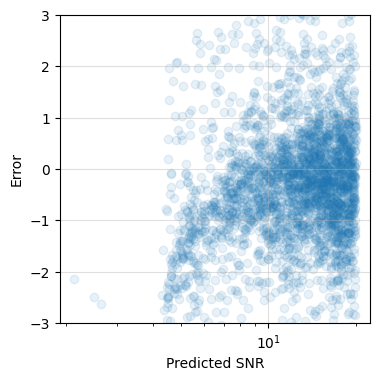

In [32]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

## ET

In [33]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("optsnr_ET_1.json")
# unlensed_params2 = get_param_from_json("optsnr_ET_2.json")
# unlensed_params3 = get_param_from_json("optsnr_ET_3.json")
# unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
# unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
# #del unlensed_params2
# del unlensed_params2, unlensed_params3

print(len(unlensed_params['ET1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['optimal_snr_net']<1000
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

len(unlensed_params['ET1'])

100000


99999

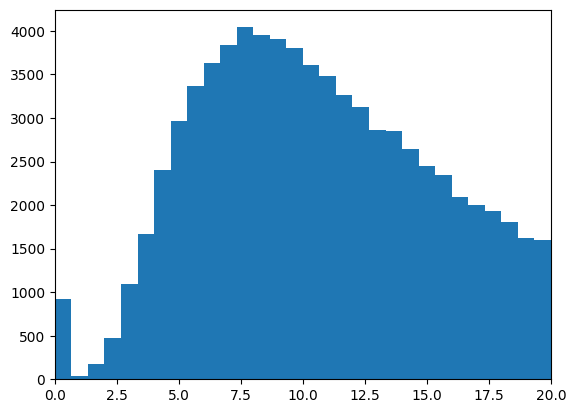

In [34]:
# visualize the data
import matplotlib.pyplot as plt
test = np.array(unlensed_params['optimal_snr_net'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [35]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR

gwsnr = GWSNR(
    mtot_max=500,
    minimum_frequency=10,
    waveform_approximant='IMRPhenomXPHM',
    snr_type='ann',
    ifos=['ET'],
)

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for ET1 detector from ./interpolator_pickle/ET1/partialSNR_dict_0.pickle
Interpolator will be loaded for ET2 detector from ./interpolator_pickle/ET2/partialSNR_dict_0.pickle
Interpolator will be loaded for ET3 detector from ./interpolator_pickle/ET3/partialSNR_dict_0.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  10
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10): 369.97199706893525
detectors:  ['ET1', 'ET2', 'ET3']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packag

In [36]:
# initialize the LeR class
from ler.rates import LeR
ler = LeR(
    npool=8,
    z_max=10,  # becareful with this value
    spin_zero=False,
    spin_precession=True,
    verbose=False,
    mtot_max=500,
    minimum_frequency=10,
    waveform_approximant='IMRPhenomXPHM',
    snr_type='inner_product',
    ifos=['ET'],
)

In [37]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = params['mass_1'][idx]
    mass_2 = params['mass_2'][idx]
    luminosity_distance = params['luminosity_distance'][idx]
    theta_jn = params['theta_jn'][idx]
    psi = params['psi'][idx]
    geocent_time = params['geocent_time'][idx]
    ra = params['ra'][idx]
    dec = params['dec'][idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    Amp = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  Amp / d_eff

    # get spin parameters
    a_1 = params['a_1'][idx]
    a_2 = params['a_2'][idx]
    tilt_1 = params['tilt_1'][idx]
    tilt_2 = params['tilt_2'][idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    XET1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    XET2 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    XET3 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T

    # output data
    # get ET snr for y train
    yET1 = params['ET1'][idx]
    yET2 = params['ET2'][idx]
    yET3 = params['ET3'][idx]


    return(XET1, XET2, XET3, yET1, yET2, yET3)

In [38]:
len_ = len(unlensed_params['ET1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XET1, XET2, XET3, yET1, yET2, yET3 = input_output(idx, unlensed_params)
np.shape(XET1)

(99999, 5)

### ET1

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XET1, yET1, test_size = 0.1, random_state = 0)

In [40]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [41]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerET1.pkl', 'wb'))

In [42]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [43]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [44]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


2813/2813 [==============================] - 1s 414us/step - loss: 52.1317 - accuracy: 7.7779e-05
Epoch 2/200
2813/2813 [==============================] - 1s 412us/step - loss: 23.3812 - accuracy: 3.3334e-05
Epoch 3/200
2813/2813 [==============================] - 1s 412us/step - loss: 17.6212 - accuracy: 4.4445e-05
Epoch 4/200
2813/2813 [==============================] - 1s 410us/step - loss: 15.0405 - accuracy: 7.7779e-05
Epoch 5/200
2813/2813 [==============================] - 1s 419us/step - loss: 13.4632 - accuracy: 7.7779e-05
Epoch 6/200
2813/2813 [==============================] - 1s 410us/step - loss: 12.3173 - accuracy: 1.0000e-04
Epoch 7/200
2813/2813 [==============================] - 1s 414us/step - loss: 11.4802 - accuracy: 1.0000e-04
Epoch 8/200
2813/2813 [==============================] - 1s 410us/step - loss: 10.8755 - accuracy: 1.0000e-04
Epoch 9/200
2813/2813 [==============================] - 1s 410us/step - loss: 10.3300 - accuracy: 1.0000e-04
Epoch 10/200
2813/2813

In [45]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

313/313 [==============================] - 0s 278us/step
[[10.51161098 10.45092506]
 [ 6.93729162  6.8640969 ]
 [33.00974274 35.93394423]
 [ 9.59559631  8.63606002]
 [ 6.8458581   7.09666884]
 [ 2.14108706  2.10222629]
 [15.06065845 15.13249964]
 [ 3.23916435  3.10575825]
 [ 6.04150391  0.        ]
 [ 5.17102814  5.24824635]
 [ 2.53053284  3.73246361]
 [10.39026737 10.67576691]
 [12.30159473 11.78558384]
 [52.48610306 47.2485469 ]
 [ 9.75172234  9.54763333]]


In [46]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.52%


In [47]:
# Save the model to a file
ann.save('ann_modelET1.h5')

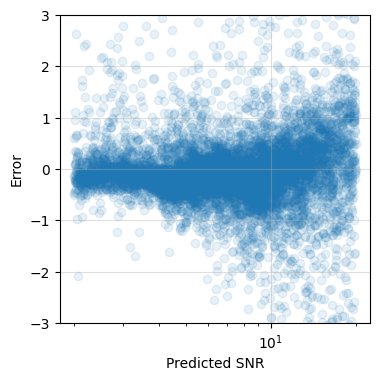

In [48]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

### ET2

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XET2, yET2, test_size = 0.1, random_state = 0)

In [50]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [51]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerET2.pkl', 'wb'))

In [52]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [53]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [54]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


2813/2813 [==============================] - 1s 423us/step - loss: 55.1792 - accuracy: 1.1111e-04
Epoch 2/200
2813/2813 [==============================] - 1s 425us/step - loss: 22.4600 - accuracy: 3.3334e-05
Epoch 3/200
2813/2813 [==============================] - 1s 426us/step - loss: 16.8020 - accuracy: 4.4445e-05
Epoch 4/200
2813/2813 [==============================] - 1s 409us/step - loss: 14.2953 - accuracy: 4.4445e-05
Epoch 5/200
2813/2813 [==============================] - 1s 413us/step - loss: 12.7616 - accuracy: 2.2222e-05
Epoch 6/200
2813/2813 [==============================] - 1s 418us/step - loss: 11.7284 - accuracy: 2.2222e-05
Epoch 7/200
2813/2813 [==============================] - 1s 410us/step - loss: 10.9202 - accuracy: 2.2222e-05
Epoch 8/200
2813/2813 [==============================] - 1s 427us/step - loss: 10.2427 - accuracy: 0.0000e+00
Epoch 9/200
2813/2813 [==============================] - 1s 419us/step - loss: 9.8338 - accuracy: 0.0000e+00
Epoch 10/200
2813/2813 

In [55]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

313/313 [==============================] - 0s 274us/step
[[17.93535614 19.07220573]
 [14.69812489 15.11335295]
 [ 3.09901714  3.55772204]
 [ 3.73456264  5.21909649]
 [ 4.68515968  5.03089526]
 [ 4.15480089  3.83825613]
 [14.90636253 15.61472477]
 [ 5.84936523  5.98259729]
 [ 7.76793432  0.        ]
 [ 1.58678722  1.96933717]
 [ 2.74391842  3.69384239]
 [ 8.39710712  9.02721124]
 [10.85793972 10.69776699]
 [39.81023026 40.74452949]
 [ 7.64491081  7.71280438]]


In [56]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.36%


In [57]:
# Save the model to a file
ann.save('ann_modelET2.h5')

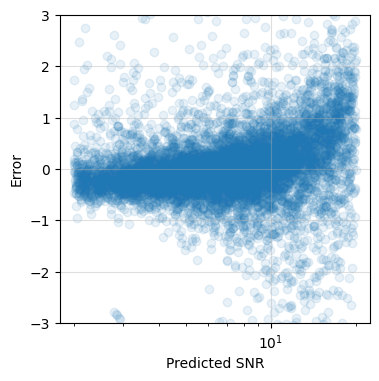

In [58]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

### ET3

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XET3, yET3, test_size = 0.1, random_state = 0)

In [60]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerET3.pkl', 'wb'))

In [62]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [63]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [64]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


2813/2813 [==============================] - 1s 427us/step - loss: 51.9026 - accuracy: 0.0000e+00
Epoch 2/200
2813/2813 [==============================] - 1s 419us/step - loss: 23.4366 - accuracy: 5.5556e-05
Epoch 3/200
2813/2813 [==============================] - 1s 422us/step - loss: 17.8154 - accuracy: 1.0000e-04
Epoch 4/200
2813/2813 [==============================] - 1s 411us/step - loss: 15.1581 - accuracy: 1.1111e-04
Epoch 5/200
2813/2813 [==============================] - 1s 415us/step - loss: 13.5741 - accuracy: 1.4445e-04
Epoch 6/200
2813/2813 [==============================] - 1s 421us/step - loss: 12.5005 - accuracy: 1.5556e-04
Epoch 7/200
2813/2813 [==============================] - 1s 416us/step - loss: 11.6430 - accuracy: 1.5556e-04
Epoch 8/200
2813/2813 [==============================] - 1s 427us/step - loss: 10.9704 - accuracy: 2.1111e-04
Epoch 9/200
2813/2813 [==============================] - 1s 416us/step - loss: 10.3611 - accuracy: 2.3334e-04
Epoch 10/200
2813/2813

In [65]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

313/313 [==============================] - 0s 272us/step
[[12.71297646 13.04187189]
 [17.17362213 18.16613305]
 [32.07108307 33.33309283]
 [ 7.44244194  7.38296436]
 [ 2.4514575   2.81988094]
 [ 4.96646547  5.16016708]
 [17.9992485  18.64626737]
 [ 7.30037069  7.98921422]
 [12.92072678  0.        ]
 [ 5.83302832  6.24162475]
 [ 2.75373936  4.60774003]
 [ 5.97950745  7.08419207]
 [ 9.20031261  9.7452399 ]
 [43.50712585 42.51342039]
 [ 9.42887115  9.53521048]]


In [66]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.98%


In [67]:
# Save the model to a file
ann.save('ann_modelET3.h5')

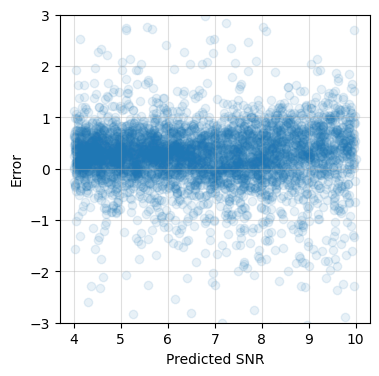

In [76]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>4) & (y_pred_<10)
plt.figure(figsize=(4,4))
plt.scatter(y_pred[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

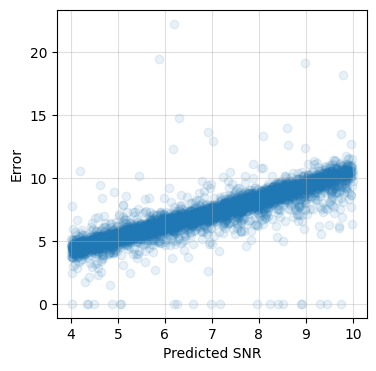

In [74]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>4) & (y_pred_<10)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.grid(alpha=0.4)
plt.show()

## Load all models and test them

In [348]:
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1.h5')
modelH1 = load_model('ann_modelH1.h5')
modelV1 = load_model('ann_modelV1.h5')

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

## BBH

In [349]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpam

In [350]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(np.array(params['L1'])[idx]**2 + np.array(params['H1'])[idx]**2 + np.array(params['V1'])[idx]**2)

    # taking care mtot max
    # mtot_max = gwsnr.mtot_max
    # mtot = mass_1[idx] + mass_2[idx]
    # y[mtot>mtot_max] = 0.

    return(X,y)

In [351]:
gwsnr.mtot_max

184.98599853446768

In [363]:
# generating new data
from ler.rates import LeR
from ler.utils import load_json
import numpy as np

ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5) 

In [364]:
## Uncomment to generate new data if not already generated
size = 10000
ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_param_testing.json', resume=False);

unlensed params will be store in ./ler_data/unlensed_param_testing.json
chosen batch size = 50000 with total size = 10000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 9444/9444 [00:18<00:00, 512.08it/s]


saving all unlensed_params in ./ler_data/unlensed_param_testing.json...


In [365]:
unlensed_params = load_json("ler_data/unlensed_param_testing.json")

In [366]:
X_, Y_ = input_output_net(np.arange(size), unlensed_params)

In [367]:
def input_output_netANN(x_array):
    x = scalerL1.transform(x_array[0])
    yL1 = modelL1.predict(x)
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(x_array,y)

In [368]:
_, snrANN =input_output_netANN(X_)

313/313 [==============================] - 0s 265us/step


In [369]:
y_pred = snrANN.flatten()
y_test = Y_

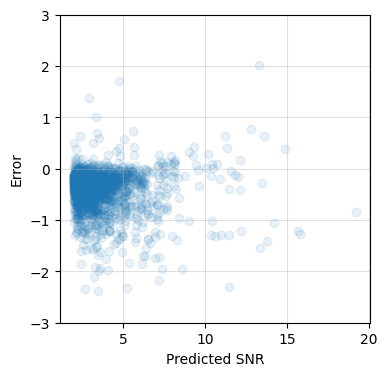

In [370]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
idx = (y_pred>2) & (y_pred<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred[idx], y_test[idx]-y_pred[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

10000
351


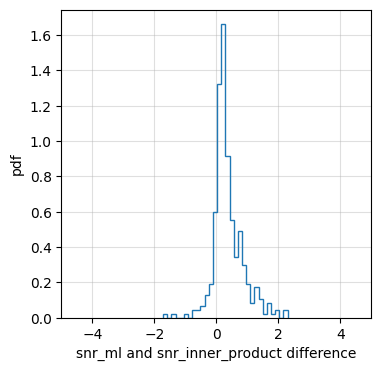

In [371]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=30, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [372]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 0.10%


In [373]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), (y_pred>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[9939    8]
 [   2   51]]


0.999

In [374]:
#y_pred = (y_pred > 0.5)
idx = (y_test>4) & (y_pred<12)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[idx][10:25])

[[5.71595097 5.25587634]
 [5.0298748  4.46367073]
 [7.11310148 6.09090852]
 [4.27560472 4.10227649]
 [5.99348545 5.80177071]
 [7.69536114 7.8197823 ]
 [4.58479786 4.19441542]
 [6.49495888 5.60346051]
 [5.12364483 4.7016174 ]
 [5.27405453 5.22435598]
 [4.554461   4.90022612]
 [4.68665695 4.63345152]
 [5.63837528 5.51643124]
 [7.93179989 8.18529239]
 [4.13582611 4.06653251]]


## BNS

In [5]:
# generating new data
from ler.rates import LeR
ler = LeR(npool=4, event_type = 'BNS', mtot_max=14, z_max = 2.0, verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [6]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_bns_ann_test.json')

unlensed params will be store in ./ler_data/unlensed_bns_ann_test.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|█████████████████████████████████████████████████████████| 50000/50000 [10:22<00:00, 80.37it/s]


saving all unlensed_params in ./ler_data/unlensed_bns_ann_test.json...


In [10]:
from ler.utils import load_json
unlensed_params = load_json('ler_data/unlensed_bns_ann_test.json')

X_, Y_ = input_output_net(np.arange(size), unlensed_params)

NameError: name 'np' is not defined